In [1]:
import torch
from architecture import resnet50
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

In [2]:
# load classes names
with open('sets/classes.txt', 'r') as f:
    classes = [l.strip() for l in f.readlines()]
print('Loaded {} classes:'.format(len(classes)))
print('\n'.join(classes))

Loaded 10 classes:
11H(ANTONY OF PADUA)
11H(JOHN THE BAPTIST)
11H(PAUL)
11H(FRANCIS)
11HH(MARY MAGDALENE)
11H(JEROME)
11H(DOMINIC)
11F(MARY)
11H(PETER)
11H(SEBASTIAN)


In [3]:
# initialize model
num_classes = 10
gradmodel = resnet50.Grad(num_classes) # Own Modification
cammodel = resnet50.CAM(num_classes)

In [4]:
# load weights
weights_path = 'model/res50.pth'
gradmodel.load_state_dict(torch.load(weights_path), strict=True)
cammodel.load_state_dict(torch.load(weights_path), strict=True)
print('Model loaded')

Model loaded


In [5]:
# set model to be run on GPU
gradmodel.cuda()
cammodel.cuda()
# set model to run on eval mode
gradmodel.eval()
cammodel.eval()

In [6]:
standard_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Lambda(lambda x: torch.unsqueeze(x, 0))
])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)


def get_cams(img, model):
    img_size = img.shape[2:]
    cams = model(img)
    high_res_cams = F.interpolate(cams, img_size, mode='bilinear', align_corners=False)
    high_res_cams = torch.squeeze(high_res_cams, 0)
    high_res_cams /= F.adaptive_max_pool2d(high_res_cams, (1, 1)) + 1e-5
    return high_res_cams

def get_score_indice(img, model, classes, class_to_check=None):
    output = model(img)
    if class_to_check:
        indice = classes.index(class_to_check)
        score = output[0][indice]
    else:
        score, indice = torch.max(output, 1)
    return score, indice

(898, 600, 3)


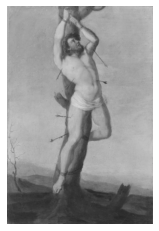

In [7]:
# load img
img_path = 'test-data/Q18599229.jpg'
image = np.asarray(imageio.imread(img_path))
print(image.shape)
plt.imshow(image)
plt.axis('off')
plt.show()

In [8]:
"""for c, p in list(zip(classes, probs)):
    print('{} - {:.4f}'.format(c, p))"""

"for c, p in list(zip(classes, probs)):\n    print('{} - {:.4f}'.format(c, p))"

In [9]:
def saliency(img, gradmodel, cammodel, classes, class_to_check=None, visual=False, smooth=False):
    if visual:
        img = standard_transform(img).cuda()
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel, classes, class_to_check)
    if score < 1:
        img.detach()
        return None, None, None
    score.backward()
    slc = torch.max(torch.abs(img.grad[0]), dim=0)[0]
    img.detach()
    vmax = torch.quantile(slc, 0.99)
    vmin = torch.min(slc)
    slc = torch.clamp(slc, vmin, vmax)
    slc = (slc - slc.min())/(slc.max()-slc.min())
    
    
    class_name = classes[indice]
    
    high_res_cams = get_cams(img, cammodel)
    high_res_cam = high_res_cams[indice].detach()
    vmax = torch.quantile(high_res_cam, 0.99)
    vmin = torch.min(high_res_cam)
    high_res_cam = torch.clamp(high_res_cam, vmin, vmax)
    high_res_cam = (high_res_cam - high_res_cam.min())/(high_res_cam.max()-high_res_cam.min())
    
    print(torch.mean(slc))
    print(torch.mean(high_res_cam))

    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        #plot image and its saliency map
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(slc.cpu().numpy(), cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(high_res_cam.cpu().numpy()[0], cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
        slc_importance = slc >= 0.5
        cam_importance = high_res_cam >= 0.5
        agreement_map = torch.logical_and(slc_importance, cam_importance)

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(agreement_map.cpu().numpy()[0], cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()
        
    return slc, high_res_cam, class_name

In [10]:
def smoothgrad(img, gradmodel, classes, class_to_check=None, stdev=0.15, nsamples=25, visual=False):
    print('hi')
    if visual:
        img = standard_transform(img).cuda()
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel, classes, class_to_check)
    if score < 1:
        img.detach()
        return None, None, None
    img.requires_grad = False
    img.detach()
    
    if class_to_check == False:
        class_to_check = classes[indice]
        
    
    total_gradients = torch.zeros_like(img[0])
    
    for _ in range(nsamples):
        noise = torch.normal(0, stdev, img.shape).cuda()
        img_plus_noise = img + noise
        img_plus_noise.requires_grad = True
        
        score, indice = get_score_indice(img_plus_noise, gradmodel, classes, class_to_check)
    
        score.backward()
        slc = torch.max(torch.abs(img_plus_noise.grad[0]), dim=0)[0]
        img_plus_noise.detach()
        vmax = torch.quantile(slc, 0.99)
        vmin = torch.min(slc)
        slc = torch.clamp(slc, vmin, vmax)
        slc = (slc - slc.min())/(slc.max()-slc.min())
        
        total_gradients += (slc * slc)
        
    smoothgrad = total_gradients / nsamples

    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        #plot image and its saliency map
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(smoothgrad.cpu().numpy()[0], cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(smoothgrad.cpu().numpy()[0], cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

    return smoothgrad, class_to_check

In [11]:
def intgrad(img, gradmodel, classes, class_to_check=None, x_steps=25, visual=False):
    if visual:
        img = standard_transform(img).cuda()
    img = torch.unsqueeze(img, 0)
    img.requires_grad = True
    
    score, indice = get_score_indice(img, gradmodel, classes, class_to_check)
    if score < 1:
        img.detach()
        return None, None, None
    img.requires_grad = False
    img.detach()
    
    if class_to_check == False:
        class_to_check = classes[indice]
    
    baseline = torch.zeros_like(img).cuda()
    total_gradients = torch.zeros_like(img)
    
    diff = img - baseline
    
    for alpha in torch.linspace(0, 1, x_steps).cuda():
        x_step = baseline + alpha * diff
        x_step.requires_grad = True
        
        score, indice = get_score_indice(x_step, gradmodel, classes, class_to_check) 
        score.backward()
        slc = x_step.grad[0]
        
        x_step.detach()
        
        total_gradients += slc
    
    integrated_gradients = total_gradients * diff / x_steps
    
    integrated_gradients = torch.max(torch.abs(integrated_gradients), dim=0)[0]
    vmax = torch.quantile(integrated_gradients, 0.99)
    vmin = torch.min(integrated_gradients)
    slc = torch.clamp(integrated_gradients, vmin, vmax)
    integrated_gradients = (slc - slc.min())/(slc.max()-slc.min())
    print(torch.mean(integrated_gradients))
    
    if visual:
        with torch.no_grad():
            input_img = inv_normalize(img[0])
        #plot image and its saliency map
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.axis('off')
        plt.show()
        
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(integrated_gradients.cpu().numpy()[0], cmap=plt.cm.hot, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(input_img.cpu().detach().numpy(), (1, 2, 0)))
        plt.imshow(integrated_gradients.cpu().numpy()[0], cmap=plt.cm.hot, alpha=0.5, vmin=0, vmax=1)
        plt.axis('off')
        plt.show()

    return integrated_gradients, class_to_check

tensor(0.0560, device='cuda:0')


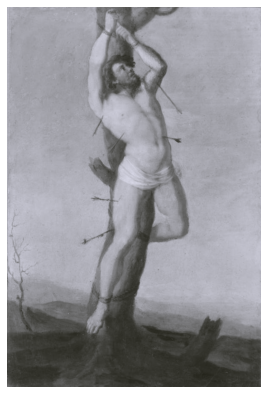

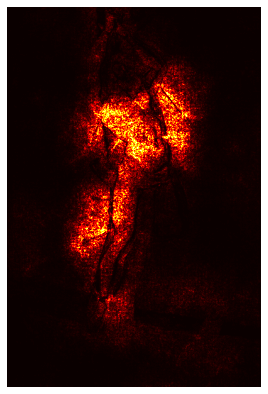

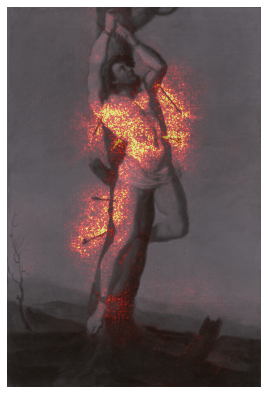

In [12]:
intgrad_value, class_name = intgrad(image, gradmodel, classes, class_to_check=None, x_steps=25, visual=True)

hi


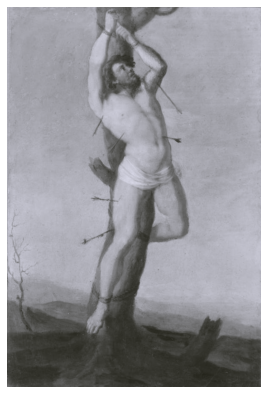

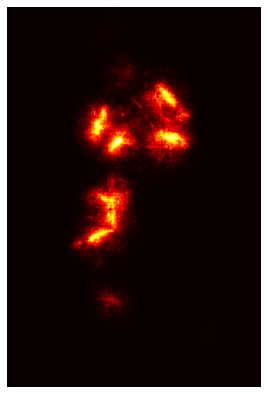

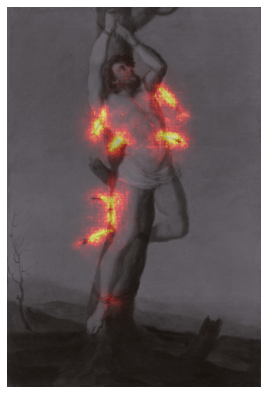

In [13]:
smoothgrad_value, class_name = smoothgrad(image, gradmodel, classes, class_to_check=None, stdev=0.15, nsamples=25, visual=True)

tensor(0.0678, device='cuda:0')
tensor(0.0547, device='cuda:0')


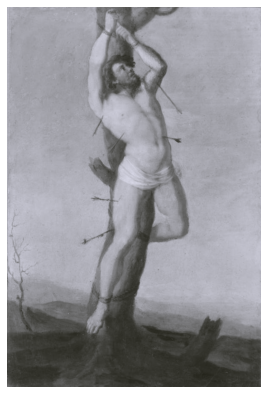

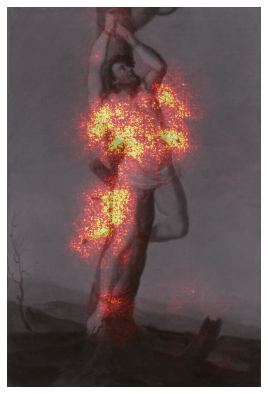

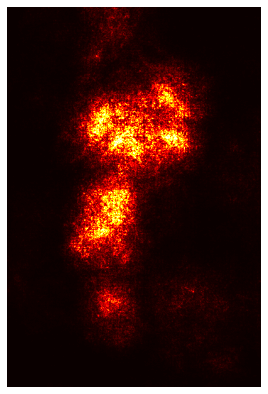

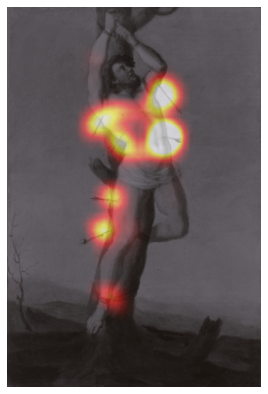

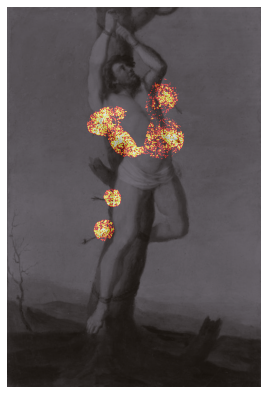

In [14]:
slc, cam, class_name = saliency(image, gradmodel, cammodel, classes, visual=True)

In [15]:
def create_subset(size_per_saint, classes):
    classes_path = 'DEVKitArtDL/DEVKitArt/ImageSets/Main'
    
    arr = np.array([])
    
    for saint in classes:
        class_size = 0
        class_path = classes_path + "/" + saint + '_train.txt'
        class_array = np.loadtxt(class_path, dtype=str)
        for image in class_array:
            if image[1] == '1':
                arr = np.append(arr, (image[0]))
                class_size += 1
            if class_size == size_per_saint:
                break
    np.savetxt(classes_path + '/' + str(size_per_saint) + '_train.txt', arr, fmt='%s')

In [57]:
create_subset(100, classes)

In [25]:
def comparison(slc, cam):
    slc_total = torch.sum(slc)
    cam_total = torch.sum(cam)
    diff = torch.abs(slc_total - cam_total)
    avg_dis = diff / torch.numel(slc)
    slc_importance = slc >= 0.5
    cam_importance = cam >= 0.5
    avg_importance_count = torch.round(torch.sum(slc_importance == True) + torch.sum(cam_importance == True) / 2) 
    agreement = torch.sum((slc_importance == cam_importance) * (slc_importance == True))
    agreement_percentage = agreement / avg_importance_count
    
    return avg_dis, agreement_percentage

    
#comparison(slc, cam)

def all_diffs(totals):
    diffs = torch.zeros(len(totals), len(totals))
    for i, x in totals:
        j=1
        while i+j+1 <= len(totals):
            diffs[i][j] = torch.abs(totals[i] - totals[j])
            diffs[j][i] = torch.abs(totals[i] - totals[j])
            j += 1
    return diffs


def comparison_full(slc, cam, smoothgrad, intgrad):
    slc_total = torch.sum(slc)
    cam_total = torch.sum(cam)
    smoothgrad_total = torch.sum(smoothgrad)
    intgrad_total = torch.sum(intgrad)
    
    totals = torch.as_tensor([[slc_total], [cam_total], [smoothgrad_total], [intgrad_total]])
    diffs = all_diffs(totals)
    
    print(diffs)
    
    '''diff = torch.abs(slc_total - cam_total)
    avg_dis = diff / torch.numel(slc)
    slc_importance = slc >= 0.5
    cam_importance = cam >= 0.5
    avg_importance_count = torch.round(torch.sum(slc_importance == True) + torch.sum(cam_importance == True) / 2) 
    agreement = torch.sum((slc_importance == cam_importance) * (slc_importance == True))
    agreement_percentage = agreement / avg_importance_count
    
    return avg_dis, agreement_percentage'''

In [16]:

#class_to_check = '11H(ANTONY OF PADUA)'
class_to_check = '10'

classes_path = 'DEVKitArtDL/DEVKitArt/ImageSets/Main'
class_path = classes_path + "/" + class_to_check + '_train.txt'


def is_correct_class(string):
    if string[-4:] != '.jpg':
        return False
    if class_to_check not in classes:
        class_array = np.loadtxt(class_path, dtype=str)
        if string[33:-4] in class_array:
            return True
        else:
            return False
    else:
        class_array = np.loadtxt(class_path, dtype=str).T
        i = np.where(class_array[0] == string[33:-4])[0]
        if class_array[1][i] == '1':
            return True
        else:
            return False
    
dataset = torchvision.datasets.ImageFolder(root='DEVKitArtDL/DEVKitArt', transform = standard_transform, is_valid_file = is_correct_class)
#dataset = torchvision.datasets.ImageFolder(root='DEVKitArtDL/DEVKitArt', transform = standard_transform)
standardloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

print(len(standardloader))

85


In [17]:
avg_distances, agreement_percentages = [], []

def com_analysis(standardloader, gradmodel, cammodel, classes, class_to_check=None):
    avg_distances, agreement_percentages = [], []
    for i, data in enumerate(standardloader, 0):
        if i % 500 == 0:
            print(i / len(standardloader))
        for j in data[0]:
            slc, cam, class_name= saliency(j.cuda(), gradmodel, cammodel, classes, class_to_check)
            if class_name == None:
                continue
            avg_dis, agreement_percentage = comparison(slc, cam)
            avg_distances.append(avg_dis.item())
            agreement_percentages.append(agreement_percentage.item())
    return avg_distances, agreement_percentages

def com_analysis_full(standardloader, gradmodel, cammodel, classes, class_to_check=None):
    avg_distances, agreement_percentages = [], []
    for i, data in enumerate(standardloader, 0):
        if i % 500 == 0:
            print(i / len(standardloader))
        for j in data[0]:
            slc, cam, class_name= saliency(j.cuda(), gradmodel, cammodel, classes, class_to_check)
            if class_name == None:
                continue
            smooth, class_name = smoothgrad(j.cuda(), gradmodel, classes, class_to_check)
            intg, class_name = intgrad(j.cuda(), gradmodel, classes, class_to_check)
            comparison_full(slc, cam, smooth, intg)
            '''avg_dis, agreement_percentage = comparison(slc, cam, smoothgrad, intgrad)
            avg_distances.append(avg_dis.item())
            agreement_percentages.append(agreement_percentage.item())
    return avg_distances, agreement_percentages'''

In [26]:
com_analysis_full(standardloader, gradmodel, cammodel, classes)#, class_to_check=class_to_check)

0.0
tensor(0.0920, device='cuda:0')
tensor(0.0534, device='cuda:0')
hi
tensor(0.0624, device='cuda:0')
<class 'torch.Tensor'>
tensor([[ 61294.0195],
        [ 35603.9102],
        [ 72066.4219],
        [124725.6406]])


ValueError: not enough values to unpack (expected 2, got 1)

In [106]:
avg_distances, agreement_percentages = com_analysis(standardloader, gradmodel, cammodel, classes, class_to_check=class_to_check)
np_avg_distances = np.array(avg_distances)
np_agreement_percentages = np.array(agreement_percentages)
print(np_avg_distances)
print(np_agreement_percentages)
print("Average Distance per pixel:")       
print(sum(np_avg_distances) / len(avg_distances))
print("Average importance agreement per image:")
print(sum(np_agreement_percentages) / len(agreement_percentages))

<ipython-input-106-b43f2565da12>:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if class_array[1][i] == '1':


170
0.0
[0.03638354 0.04096285 0.0536575  0.02158294 0.04931831 0.06158427
 0.04391575 0.03811371 0.03860312 0.05629972 0.04463233 0.05260355
 0.04218957 0.03225624 0.063085   0.04076014 0.04390481 0.02262157
 0.0452338  0.05219267 0.03187384 0.05443464 0.02086057 0.02491696
 0.02658148 0.04642858 0.04335601 0.05300875 0.04622605 0.04430085
 0.05118039 0.05177923 0.03892973 0.02848012 0.04719451 0.04704806
 0.03372214 0.03920786 0.02942113 0.02939368 0.03546399 0.05464561
 0.03108606 0.03627767 0.04437967 0.04561615 0.02958033 0.03098263
 0.04758324 0.03171706 0.04684398 0.03804822 0.04508887 0.06260818
 0.03050763 0.0381711  0.06355526 0.03585457 0.0433542  0.0272909
 0.04566788 0.04981072 0.00686585 0.021063   0.04337515 0.05144884
 0.03055868 0.02680518 0.04069855 0.04665694 0.05839827 0.0349008
 0.04567948 0.02234017 0.05183811 0.04148457 0.0523359  0.04968434
 0.0533112  0.06485768 0.05134733 0.04912381 0.04250472 0.04370235
 0.05248889 0.04543992 0.03860077 0.04228755 0.03494385 

In [56]:
np_avg_distances = np.array(avg_distances)
np_agreement_percentages = np.array(agreement_percentages)

np.savetxt("saliency/np_avg_distances.csv", np_avg_distances, delimiter=",")
np.savetxt("saliency/np_agreement_percentages.csv", np_agreement_percentages, delimiter=",")

In [19]:
print("Average Distance per pixel:")       
print(sum(np_avg_distances) / len(avg_distances))
print("Average importance agreement per image:")
print(sum(np_agreement_percentages) / len(agreement_percentages))

Average Distance per pixel:
0.04192818501753546
Average importance agreement per image:
0.2363789214999065
